# Preprocessing and Modeling

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics, model_selection, svm #found on sklearn ROC Curve docs

In [2]:
warnings.filterwarnings('ignore')

In [3]:
subreddit_df = pd.read_csv('../data/clean_data.csv') #read in clean data

In [4]:
subreddit_df.isna().sum() #check nans

subreddit           0
title               0
author              0
title_length        0
title_word_count    0
clean_title         0
dtype: int64

In [5]:
subreddit_df = subreddit_df.dropna() #drop nans

In [6]:
subreddit_df

,subreddit,title,author,title_length,title_word_count,clean_title
0,Bitcoin,Keep being impressed by the S2FX model by Plan...,Scream1e,83,15,keep impressed s2fx model planb well predicts ...
1,Bitcoin,Perhaps someone will be able to support the fa...,bel-svoboda,76,14,perhaps someone able support family political ...
2,Bitcoin,Bears to the gulag!,heist95,19,4,bear gulag
3,Bitcoin,Can we have honest discussion about side effec...,Manic_Miner2,79,13,honest discussion side effect always positive
4,Bitcoin,Active nfl player going to convert full salary...,Crafty_Supermarket15,57,10,active nfl player going convert full salary bi...
...,...,...,...,...,...,...
18734,wallstreetbets,SNDL to the moon 🚀🚀🚀🚀🚀🚀 yolo!!,fk232323,30,6,sndl moon yolo
18735,wallstreetbets,I sent a gift to Ken Griffin at Citadel from A...,StockWizard_,119,21,sent gift ken griffin citadel amazon com guide...
18736,wallstreetbets,Ay bawse,z00tsuitnboogie,8,2,ay bawse
18737,wallstreetbets,GME/WSB Hype Vid (Haven't personally seen one ...,DistinguishedJB,90,18,gme wsb hype vid personally seen one week two ...


In [7]:
subreddit_df = subreddit_df[['title', 'clean_title', 'subreddit']] #Only features we want

In [8]:
subreddit_df

,title,clean_title,subreddit
0,Keep being impressed by the S2FX model by Plan...,keep impressed s2fx model planb well predicts ...,Bitcoin
1,Perhaps someone will be able to support the fa...,perhaps someone able support family political ...,Bitcoin
2,Bears to the gulag!,bear gulag,Bitcoin
3,Can we have honest discussion about side effec...,honest discussion side effect always positive,Bitcoin
4,Active nfl player going to convert full salary...,active nfl player going convert full salary bi...,Bitcoin
...,...,...,...
18734,SNDL to the moon 🚀🚀🚀🚀🚀🚀 yolo!!,sndl moon yolo,wallstreetbets
18735,I sent a gift to Ken Griffin at Citadel from A...,sent gift ken griffin citadel amazon com guide...,wallstreetbets
18736,Ay bawse,ay bawse,wallstreetbets
18737,GME/WSB Hype Vid (Haven't personally seen one ...,gme wsb hype vid personally seen one week two ...,wallstreetbets


### Modeling

In [9]:
X = subreddit_df['clean_title'] #lets score on our clean title 
y = subreddit_df['subreddit'] #our target
y = y.map({'Bitcoin': 1, 'wallstreetbets': 0}) #remap

In [10]:
y.value_counts(normalize = True) #baseline score, we want to score better than 0.508563, not very good! We can do it
#we can naturely score a 0.508563, which is essentially a coin flip, let's build a predicitng model to beat it.
# The baseline accuracy is the percentage of the majority class, regardless of whether it is 1 or 0. It serves as the benchmark for our model to beat!

1    0.508565
0    0.491435
Name: subreddit, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

### Model with CountVectorizer and Logistic Regression

In [12]:
pipe = make_pipeline(CountVectorizer(), LogisticRegression())

#hyperparameters that we will test across
params = {
'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'countvectorizer__stop_words': ['english'],
'logisticregression__penalty': ['l1','l2'],
'logisticregression__C': [0.1, 1, 10]
}

#GridSearch
gs_cvect_lrg = GridSearchCV(pipe, params, n_jobs=-1)
gs_cvect_lrg.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'countvectorizer__stop_words': ['english'],
                         'logisticregression__C': [0.1, 1, 10],
                         'logisticregression__penalty': ['l1', 'l2']})

In [13]:
gs_cvect_lrg.score(X_train, y_train) #slightly overfit

0.9799345382097624

In [14]:
gs_cvect_lrg.score(X_test, y_test) #not bad score

0.8678762006403415

In [15]:
gs_cvect_lrg.best_params_

{'countvectorizer__ngram_range': (1, 3),
 'countvectorizer__stop_words': 'english',
 'logisticregression__C': 1,
 'logisticregression__penalty': 'l2'}

### Model with TfidfVectorizer and Logistic Regression

In [16]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())


params = {
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'tfidfvectorizer__stop_words': ['english'],
'logisticregression__penalty': ['l1', 'l2'],
'logisticregression__C': [0.1, 1, 10]
}

gs_tfidf_lgr = GridSearchCV(pipe, params, n_jobs=-1)
gs_tfidf_lgr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 10],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'tfidfvectorizer__stop_words': ['english']})

In [17]:
gs_tfidf_lgr.score(X_train, y_train) #less overfit than cvect

0.9628575494521133

In [18]:
gs_tfidf_lgr.score(X_test, y_test) #slightly worse score

0.8676627534685165

In [19]:
gs_tfidf_lgr.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l2',
 'tfidfvectorizer__ngram_range': (1, 3),
 'tfidfvectorizer__stop_words': 'english'}

### Model with CountVectorizer and Naive Bayes

In [20]:
pipe = make_pipeline(CountVectorizer(), MultinomialNB())


params = {
'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'countvectorizer__stop_words': ['english'],
'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
}

gs_cvect_naive = GridSearchCV(pipe, params, n_jobs=-1)
gs_cvect_naive.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'countvectorizer__stop_words': ['english'],
                         'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]})

In [21]:
gs_cvect_naive.score(X_train, y_train) #even less overfit!

0.96058061761776

In [22]:
gs_cvect_naive.score(X_test, y_test) #highest score! fastest runtime! This will be our final model

0.8706510138740662

### Model with TfidfVectorizer and Naive Bayes

In [23]:
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())

params = {
'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
'tfidfvectorizer__stop_words': ['english'],
'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
}

gs_tfidf_naive = GridSearchCV(pipe, params, n_jobs=-1)
gs_tfidf_naive.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'tfidfvectorizer__stop_words': ['english']})

In [24]:
gs_tfidf_naive.score(X_train, y_train) #more overfit than cvect naive

0.9736018215454675

In [25]:
gs_tfidf_naive.score(X_test, y_test) #slightly worse score than cvect and more overfit,  we choose our cvect_naive model!

0.8695837780149414

In [26]:
# cvect_naive model has the highest score, is the least overfit, and runs the fastest. A model that gives us the best results in the shortest amount of time
# is a model we want. This is my defense for using our  Naive Bayes model.

#it is a bit overfit, which is a bit of a downfall, but sacrificing our overfit-ness for a lower score is not something I would approve.
#I would much rather have a higher score on my test data with an overfit model than a lower score with a not so overfit model.
#A score of 0.87... in subreddit prediction is excellent! Our titles are succesfull in predicting subreddits.

### Final Model: Cvect with Naive Bayes 

In [27]:
gs_cvect_naive.best_params_ #best params for our cvect Naive Bayes model, let's run the same model for Wall Street Bets below

{'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__stop_words': 'english',
 'multinomialnb__alpha': 1.0}

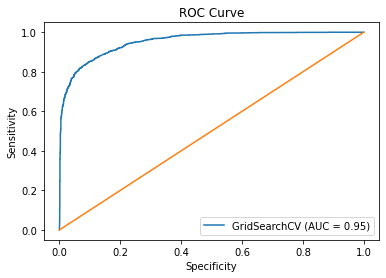

In [28]:
metrics.plot_roc_curve(gs_cvect_naive, X_test, y_test);
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.title('ROC Curve')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity'); #ROC Curve shows great performance

In [29]:
X2 = subreddit_df['clean_title'] #lets score on our clean title 
y2 = subreddit_df['subreddit'] #our target
y2 = y2.map({'Bitcoin': 0, 'wallstreetbets': 1}) #remap again

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y2, random_state = 0)


pipe_wsb = make_pipeline(CountVectorizer(), MultinomialNB())

params = {
'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'countvectorizer__stop_words': ['english'],
'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
}

gs_cvect_naive_wsb = GridSearchCV(pipe_wsb, params, n_jobs=-1)
gs_cvect_naive_wsb.fit(X_train2, y_train2)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'countvectorizer__stop_words': ['english'],
                         'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]})

In [30]:
gs_cvect_naive_wsb.score(X_train2, y_train2)

0.9693325743560552

In [31]:
gs_cvect_naive_wsb.score(X_test2, y_test2)

0.8597652081109926

In [32]:
gs_cvect_naive_wsb.best_params_ #we will use this data as well

{'countvectorizer__ngram_range': (1, 3),
 'countvectorizer__stop_words': 'english',
 'multinomialnb__alpha': 1.0}

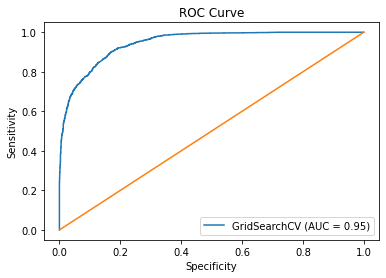

In [33]:
metrics.plot_roc_curve(gs_cvect_naive_wsb, X_test2, y_test2);
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.title('ROC Curve')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity'); #ROC Curve shows great performance

# Evaluation and Conceptual Understanding

### Most Predictive r/bitcoin Words

In [34]:
coefs = (gs_cvect_naive.best_estimator_.named_steps['multinomialnb'].coef_).T
coefs = pd.DataFrame(coefs)
coefs.columns = ['coef']

coefs['words'] = gs_cvect_naive.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coefs = coefs.sort_values('coef', ascending = False)

In [35]:
coefs.head(20) #quick look at top 20 words

,coef,words
8043,-3.952265,bitcoin
10399,-5.374243,btc
15841,-5.493590,crypto
11084,-5.992167,buy
57860,-6.424066,wallet
18084,-6.455814,dip
37849,-6.479125,new
35854,-6.542407,mining
1305,-6.547445,2021
54110,-6.552508,time


In [36]:
#bitcoin
#btc is the abbreviation for bitcoin
#crypto
#dip (buy the dip! (in price))
#wallet (hardware wallet to store bitcoin)
#mining is bitcoin mining
#coinbase is a crypto market/trading platform for bitcoin and other cryptocurrencies

### Most Predictive r/wallstreetbets Words

In [37]:
coefs2 = (gs_cvect_naive_wsb.best_estimator_.named_steps['multinomialnb'].coef_).T
coefs2 = pd.DataFrame(coefs2)
coefs2.columns = ['coef']

coefs2['words'] = gs_cvect_naive_wsb.best_estimator_.named_steps['countvectorizer'].get_feature_names()
coefs2 = coefs2.sort_values('coef', ascending = False)

In [38]:
coefs2.head(20)

,coef,words
90565,-6.037630,stock
65982,-6.132519,mvis
43379,-6.153572,gme
65099,-6.222059,moon
86460,-6.348742,short
8702,-6.435753,ape
19913,-6.461152,buy
106719,-6.487212,yolo
7562,-6.703776,amc
67309,-6.789298,new


In [39]:
#wsb is all about yoloing and making risky bets on stocks
#mvis is a popular stock in wsb at the moment and redditors have been trying to pump it similarly like GME was pumped at the beginning of the year
#wsb redditors frequently say '{stock name} to the moon!' with a bunch of emojis
#wsb redditors call themselves apes with diamond hands
#amc another popular stock, and gme is still popular as well

### Confusion Matrix Analysis

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix

In [41]:
preds = gs_cvect_naive.predict(X_test)

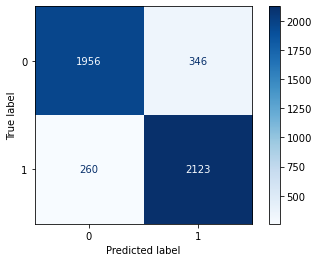

In [42]:
plot_confusion_matrix(gs_cvect_naive, X_test, y_test, cmap = 'Blues');

In [43]:
print(classification_report(y_test, preds, digits = 4)) #found this function here https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

              precision    recall  f1-score   support

           0     0.8827    0.8497    0.8659      2302
           1     0.8599    0.8909    0.8751      2383

    accuracy                         0.8707      4685
   macro avg     0.8713    0.8703    0.8705      4685
weighted avg     0.8711    0.8707    0.8706      4685



In [44]:
#our scores are quite good
#only 346 False Positive and 260 False Negatives
#considering that these subreddits are not completley different, our scores are much better than .50, our baseline
#our f1 score(accuracy) is quite good as well, we'll take it!

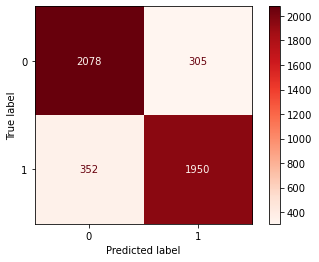

In [45]:
plot_confusion_matrix(gs_cvect_naive_wsb, X_test2, y_test2, cmap = 'Reds');

In [46]:
preds2 = gs_cvect_naive_wsb.predict(X_test2)
print(classification_report(y_test2, preds2, digits = 4))

              precision    recall  f1-score   support

           0     0.8551    0.8720    0.8635      2383
           1     0.8647    0.8471    0.8558      2302

    accuracy                         0.8598      4685
   macro avg     0.8599    0.8595    0.8597      4685
weighted avg     0.8599    0.8598    0.8597      4685



In [47]:
#our scores are quite good her as well
#only 305 False Positive and 352 False Negatives
#considering that these subreddits are not completley different, our scores are much better than .50, our baseline
#our f1 score(accuracy) is quite good as well, we'll take it!

### Usings Predicitons to find the most Predictive Titles associated with each Subreddit

In [48]:
predictions = pd.DataFrame(gs_cvect_naive.predict_proba(X))

In [49]:
predictions['clean_title'] = subreddit_df['clean_title']

In [50]:
predictions.sort_values(1, ascending = False)[:20] #titles most strongly predicting bitcoin

,0,1,clean_title
4293,1.065537e-16,1.0,bitcoin hoje binance coin vale pena comprar em...
6969,3.626290e-25,1.0,looking high reward defi gem cryptoswap financ...
8752,2.840480e-16,1.0,start mining crypto today best offer crypto mi...
7540,2.239572e-36,1.0,riot acquire whinstone creating u based indust...
6278,8.438369e-25,1.0,turkish central bank ban accepting crypto paym...
1692,2.696021e-15,1.0,bitcoin btc grafik bitcoin 24 nisan 21 mayıs a...
4771,2.515635e-19,1.0,checked bitcoin balance amount bitcoin still p...
296,2.458111e-17,1.0,usa skrill per inviare denaro ad amici parenti...
9214,2.465840e-16,1.0,multi billion dollar cache microstrategy purch...
4199,2.829753e-25,1.0,hi dear reedit today found google drive propab...


In [64]:
predictions2 = pd.DataFrame(gs_cvect_naive_wsb.predict_proba(X2))
predictions2['clean_title'] = subreddit_df['clean_title']
predictions2.sort_values(1, ascending = False)[:20] #titles most strongly predicting wallstreets

,0,1,clean_title
11991,4.652840e-61,1.0,ocgn ocugen bharat biotech covaxin announcemen...
16975,6.521488e-19,1.0,amc 04 may 2021 shareholders' meeting let's op...
16978,4.161342e-23,1.0,holy fucking shit think figured launched yet p...
14657,4.987745e-35,1.0,long term biotech play 110 one day gain option...
11267,2.928718e-17,1.0,kdkgf ape buy gold low early temptation $5 k y...
16981,5.573709e-17,1.0,microvision finding proper valuation hint $17....
11264,3.965369e-20,1.0,since beginning gme trust think clov trap neve...
13872,1.252520e-19,1.0,anyone looking recaf potentially life changing...
18273,1.274085e-22,1.0,gmgi profitable online casino esports sportsbe...
11261,2.928718e-17,1.0,kdkgf ape buy gold low early temptation $5 k y...


# Conclusions and Recommendations

### Steps for Project Completion

1. We gathered/collected our data using api rquests and pushshift, and built a function to place that data into a dataframe.
   We were interested in the subreddits r/bitcoin and r/wallstreetbets, two subreddits focused on investing.

2. After Data collection, we cleaned our data by tokenizing/lemmatizing our titles, engineering some additional features, and removing null values.
   With our new clean titles, I created some visualizion and conducted proper EDA to better understand the data collected for proper model analysis in the future

3. Preproccesed our subreddit Data, train-test-split our X and y variables, and created models such as Logistic Regression and Naive Bayes, for scoring and   predicting both the Bitcoin and WallStreetBets Subreddits. Created visualizations of our modeled data and predictive variables, created a confusion matrix for analysis, analyszed coeficients and probabilites as well.

### Conclusions

We can accuratley predict which subreddit a title is from with an accuracy over 85%, a great achievment.
These subreddits are fairly similar, but with particular individual characteristics we are able to predict accurately.
Through the process of cleaning our titles and predictive modeling, we did quite well.

We notice that r/wallstreetbets has many keywords, such as GME, MVIS, AMC, yolo, ape, etc., these keywords on top of it's meme-y community act as a bit of a separation between r/bitcoin.
r/bitcoin on the other hand is also an investing subreddit, but it's main focus is on bitcoin/btc rather than stocks, but also tends to quite meme-y. 
Another interesting point is that these subreddits frequently refer to eachother and their communities, with many subscribers that are part of both communities. 

r/bitcoin focus more on investing/studying bitcoin, r/wallstreetbets focuses more on yoloing risky stocks and posting about them for internet points. The things that bring them together are: investing, money, memes, and humor.

If conducting a similar project with different subreddits, I would recommend gathering over 10,000 data entries and to clean the data very thoroughl. Use different modeling techniques as well to get the best accuracy possible.

### Further Research

I believe I can generate even more accurate data if I were able to take every title from each subreddit since its inception efficiently. Currently I do not have the knowledge to do that quickly, and that would be very interesting to see the difference between that data and mine.

In the future I would also recommend to try different types of models, possible some boosting/KNN/tree to see what types of results those models bring.
It would also be interesting to try out some other vectorizers outside of CountVectorizer and TfdifVectorizer.

Exploring different ways to Tokenize/Lematize/Clean the data I'm sure would yield different and intersting results as well. (i.e. spacy)

In [52]:
#streamlit test

In [61]:
X3 = subreddit_df['title']

In [65]:
predictions3 = pd.DataFrame(gs_cvect_naive_wsb.predict_proba(X3))
predictions3['title'] = subreddit_df['title']

In [66]:
predictions3

,0,1,title
0,9.930970e-01,6.903030e-03,Keep being impressed by the S2FX model by Plan...
1,9.973852e-01,2.614832e-03,Perhaps someone will be able to support the fa...
2,6.580425e-01,3.419575e-01,Bears to the gulag!
3,5.015037e-01,4.984963e-01,Can we have honest discussion about side effec...
4,1.000000e+00,1.761621e-11,Active nfl player going to convert full salary...
...,...,...,...
18734,2.846016e-06,9.999972e-01,SNDL to the moon 🚀🚀🚀🚀🚀🚀 yolo!!
18735,1.058864e-09,1.000000e+00,I sent a gift to Ken Griffin at Citadel from A...
18736,9.419574e-02,9.058043e-01,Ay bawse
18737,9.652730e-05,9.999035e-01,GME/WSB Hype Vid (Haven't personally seen one ...


In [67]:
predictions3.to_csv('../data/predictions3.csv', index = False)

In [68]:
predictions3 = pd.read_csv('../data/predictions3.csv') #read in clean data

In [69]:
predictions3

,0,1,title
0,9.930970e-01,6.903030e-03,Keep being impressed by the S2FX model by Plan...
1,9.973852e-01,2.614832e-03,Perhaps someone will be able to support the fa...
2,6.580425e-01,3.419575e-01,Bears to the gulag!
3,5.015037e-01,4.984963e-01,Can we have honest discussion about side effec...
4,1.000000e+00,1.761621e-11,Active nfl player going to convert full salary...
...,...,...,...
18734,2.846016e-06,9.999972e-01,SNDL to the moon 🚀🚀🚀🚀🚀🚀 yolo!!
18735,1.058864e-09,1.000000e+00,I sent a gift to Ken Griffin at Citadel from A...
18736,9.419574e-02,9.058043e-01,Ay bawse
18737,9.652730e-05,9.999035e-01,GME/WSB Hype Vid (Haven't personally seen one ...
